# Preliminaries

In [2]:
import os
import numpy as np 
import pandas as pd
import re
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

pd.set_option('display.max_columns', None)

# Data Retrieval Functions

In [9]:
def time_converter(x):
    if isinstance(x, str): 
        pattern = r'(\d+):(\d+)'
        match = re.match(pattern, x)
        if match:
            minutes = float(match.group(1))
            seconds = float(match.group(2)) / 100
            time = minutes + seconds
            return time
    elif isinstance(x, (int, float)) or np.isnan(x):
        return 0

def import_data(folder_path, y_var_name, training=True):
    '''
    This function retrieves the raw data and aggregates it.
    Note that the first dataframe includes data for the '17-'18 season. Each added frame
    is from the following season. So the last frame is the '22-'23 season.
    '''
    
    dataframe_list = []
    csv_files = [filename for filename in os.listdir(folder_path) if filename.endswith('.csv')]
    csv_files.sort(key=lambda filename: int(filename.split('-')[0]), reverse=True)

    for filename in csv_files:
        file_path = os.path.join(folder_path, filename)
        data = pd.read_csv(file_path)
        dataframe_list.append(data)
    y_var = dataframe_list[0][['ID', y_var_name]] 
    if training:
        dataframe_list.pop(0)
    else:
        dataframe_list.pop(3)
    
    return y_var, dataframe_list

def build_frame(data_list, training=True):
    '''
    This function builds a single dataframe from a list of similarly organized dataframes.
    It also removes the columns I don't need and does a good portion of the data cleaning.
    '''
    
    all_data = []
    for frame in range(len(data_list)):
        data_list[frame] = data_list[frame][data_list[frame]['Team'] != '(N/A)']
        data_list[frame] = data_list[frame][data_list[frame]['FPts'] != 0]
        data_list[frame] = pd.get_dummies(data_list[frame], columns=['Team', 'Position'])
        data_list[frame].drop(columns=['FP/G', 'FPts','Player', 'Status', 'Opponent', 'Salary', 'Contract', 'RkOv', 'ADP', '%D'], inplace=True)
        data_list[frame].loc[:, 'TOIES':'TOISH'] = data_list[frame].loc[:, 'TOIES':'TOISH'].map(time_converter)
        data_list[frame]['Ros'] = data_list[frame]['Ros'].map(lambda x: x.replace('-', '0'))
        data_list[frame]['Ros'] = data_list[frame]['Ros'].map(lambda x: x.rstrip('%'))
        data_list[frame]['Ros'] = data_list[frame]['Ros'].astype(float)
        data_list[frame]['Ros'] = data_list[frame]['Ros']/100
        if training:   
            data_list[frame]['Age'] = data_list[frame]['Age'] - frame - 2
        else:
            data_list[frame]['Age'] = data_list[frame]['Age'] - frame - 1
        if frame != 0:
            data_list[frame].columns = data_list[frame].columns.map(lambda x: x if x == 'ID' else x + f'_t_minus_{frame}')
        if frame == 0:
            all_data = data_list[frame]
        else:
            all_data = pd.merge(all_data, data_list[frame], on='ID', suffixes = ('', ''))
    all_data.reset_index(inplace=True, drop=True)

    return all_data

# Getting Data

In [14]:
folder_path = 'Modelling Data'
y_var_name = 'FP/G'

# Modelling Data
y_var, data_list = import_data(folder_path, y_var_name)
data = build_frame(data_list)
all_data = y_var.merge(data, on='ID')
y_var = all_data[['ID', y_var_name]]
data = all_data.drop(columns=y_var_name)

# Prediction Data
pred_data_list = import_data(folder_path, y_var_name, False)[1]
pred_data = build_frame(pred_data_list, False)

# Ensuring columns are same in both
common_columns = [col for col in pred_data.columns if col in data.columns]
data = data[common_columns]
pred_data = pred_data[common_columns]

# Pre-processing Function

In [11]:
def add_trend(data, bounds, shift):
    '''
    Adds some trend variables
    '''

    data_copy = data.copy()
    for index in range (bounds[0],bounds[1]):
        data_copy[f'{data_copy.columns[index]}_oneyrtr'] = data_copy.iloc[:,index] - data_copy.iloc[:,index+shift]
        data_copy[f'{data_copy.columns[index]}_twoyrtr'] = data_copy.iloc[:,index] - data_copy.iloc[:,index+(shift*2)]

    return data_copy

def add_poly(data, power):
    '''
    This function will add polynomial terms, including interactions, to the dataset.
    '''

    data_copy = data.iloc[:, 1:].copy()
    poly = PolynomialFeatures(degree=power, interaction_only=False, include_bias=False)
    X_poly = poly.fit_transform(data_copy)
    X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(data_copy.columns))
    X_poly_df = pd.concat([data.iloc[:,0].copy(), X_poly_df], axis=1)

    return X_poly_df


def standardize_prep(data):
    '''
    This function will take the dataframe, clean and process it, then returns a dataframe 
    ready for further processing. It also returns the names of the x variables
    '''

    xvarnames = list(data.columns[1:])
    scaler = StandardScaler()

    X = data[xvarnames]
    X_scaled = scaler.fit_transform(X)

    return xvarnames, X_scaled

def lasso_regression(data, y_vector, reg_bounds, num_regs):
    '''
    Fits a lasso model and also returns the features deemed important by the Lasso
    '''

    xvarnames, X_scaled = standardize_prep(data)
    param_grid = {
        'alpha' : np.linspace(reg_bounds[0], reg_bounds[1], num_regs)
    }
    lasso_reg = linear_model.Lasso(tol=0.25)

    # Regularization Parameter Selection
    grid_search = GridSearchCV(lasso_reg, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
    grid_search.fit(X_scaled, y_vector)

    # Retrieve the selected features (coefficients that are non-zero) based on 1 se rule
    mse_values = -grid_search.cv_results_['mean_test_score']  # Convert negative MSE to MSE
    important_var_index = np.where(grid_search.best_estimator_.coef_ != 0)[0]
    important_varnames = [xvarnames[i] for i in important_var_index]

    # Plot MSE against Lambda
    lambdas = param_grid['alpha']
    plt.figure(figsize=(10, 6))
    plt.plot(lambdas, mse_values, linestyle='-')
    plt.xlabel('Lambda')
    plt.ylabel('Mean Squared Error')
    plt.title('MSE vs. Lambda')
    plt.grid(True)
    plt.show()

    return mse_values, important_varnames

# Pre-processing

Adding variable transformations to the dataset

In [12]:
data_extra = add_trend(data, (2,20), 62)
data_poly = add_poly(data_extra, 2)
pred_data_extra = add_trend(pred_data, (2,20), 62)
pred_data_poly = add_poly(pred_data_extra, 2)

Perform a Lasso Regression to see what variables it selects

Fitting 10 folds for each of 201 candidates, totalling 2010 fits


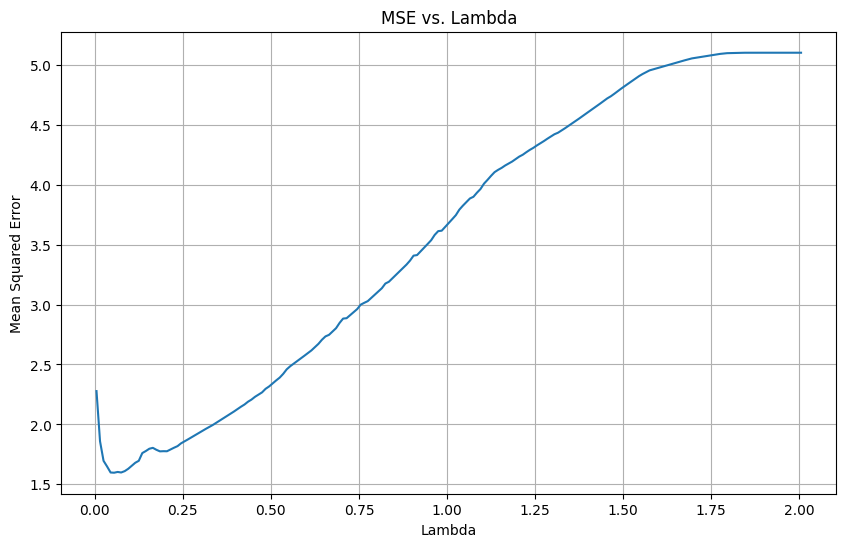

In [13]:
lasso_mses, x_var_names = lasso_regression(data_poly, y_var[y_var_name].values, (0.005,2.005), 201)

Create parsimonious dataset

In [23]:
print(len(x_var_names))
data_pars = data_poly[['ID'] + x_var_names]
pred_data_pars = pred_data_poly[['ID'] + x_var_names]
data_pars

125


,ID,Ros,GP,G,A1,SOG,Position_D,Age_t_minus_1,GP_t_minus_1,G_t_minus_1,SOG_t_minus_1,Shot%_t_minus_1,Hit_t_minus_1,Age_t_minus_2,Ros_t_minus_2,GP_t_minus_2,G_t_minus_2,SOG_t_minus_2,Hit_t_minus_2,A2_twoyrtr,Age Ros,Age Shot%_t_minus_1,Age Ros_t_minus_2,Age A2_twoyrtr,Ros^2,Ros GP,Ros Blk,Ros TOIES,Ros TOISH,Ros Position_D,Ros Position_D_t_minus_1,Ros Cor_t_minus_2,Ros Position_D_t_minus_2,Ros GP_oneyrtr,Ros Shot%_twoyrtr,Ros TS%_oneyrtr,Ros TOISH_oneyrtr,G^2,G A1,G SOG,G Team_COL,G Team_TOR,G G_t_minus_1,G PPP_t_minus_1,G Cor_t_minus_1,G A2_t_minus_2,G Cor_t_minus_2,G Shot%_twoyrtr,G TS%_oneyrtr,A Shot%_twoyrtr,A1 Shot%_twoyrtr,A2 Shot%_twoyrtr,PPP TOISH_t_minus_2,PPP Cor_t_minus_2,PPP Shot%_twoyrtr,PPP TS%_oneyrtr,PPP TOISH_oneyrtr,Cor Shot%_twoyrtr,Cor TS%_oneyrtr,Team_CAR Blk_t_minus_1,Team_CBJ Position_LW,Team_CBJ Position_LW_t_minus_1,Team_COL Position_C,Team_COL Position_C_t_minus_1,Team_COL Hit_t_minus_2,Team_COL TS%_twoyrtr,Team_DAL Cor_t_minus_2,Team_DAL Shot%_oneyrtr,Team_MIN G_t_minus_2,Team_MIN A2_t_minus_2,Team_MTL Position_RW,Team_MTL GP_t_minus_1,Team_MTL Hit_t_minus_1,Team_MTL Blk_t_minus_1,Team_MTL Position_RW_t_minus_1,Team_MTL Ros_oneyrtr,Team_MTL PPP_oneyrtr,Team_NSH Position_RW,Team_NSH G_t_minus_1,Team_NSH Shot%_t_minus_1,Team_NYI A2_t_minus_2,Team_NYR G_oneyrtr,Team_TOR G_t_minus_1,Team_TOR Cor_t_minus_2,Team_TOR Ros_twoyrtr,Team_UTA TOISH_oneyrtr,Team_VGK A1_oneyrtr,Position_C Shot%_twoyrtr,"Position_C,LW PIM_twoyrtr","Position_C,RW Shot%_t_minus_2","Position_C,RW TS%_t_minus_2","Position_LW,RW Shot%_twoyrtr","Position_LW,RW TS%_oneyrtr",Position_RW Team_NSH_t_minus_1,Age_t_minus_1 GP_t_minus_2,Ros_t_minus_1 GP_oneyrtr,GP_t_minus_1 Team_MTL_t_minus_1,GP_t_minus_1 Age_t_minus_2,Shot%_t_minus_1 Team_NSH_t_minus_1,Shot%_t_minus_1 Team_NSH_t_minus_2,Blk_t_minus_1 Team_MTL_t_minus_1,Blk_t_minus_1 Team_MTL_t_minus_2,Team_COL_t_minus_1 Position_C_t_minus_1,Team_COL_t_minus_1 Position_C_t_minus_2,Team_COL_t_minus_1 TS%_twoyrtr,Team_FLA_t_minus_1 Position_C_t_minus_1,Team_NSH_t_minus_1 Position_RW_t_minus_1,Team_NYR_t_minus_1 G_oneyrtr,Team_TOR_t_minus_1 Cor_t_minus_2,Team_VGK_t_minus_1 A1_oneyrtr,Position_C_t_minus_1 Shot%_twoyrtr,Position_RW_t_minus_1 Team_NSH_t_minus_2,Age_t_minus_2 GP_t_minus_2,Ros_t_minus_2 GP_oneyrtr,Hit_t_minus_2 A2_twoyrtr,Cor_t_minus_2 TOIPP_oneyrtr,Team_CBJ_t_minus_2 Position_LW_t_minus_2,Team_FLA_t_minus_2 Position_C_t_minus_2,Team_NYR_t_minus_2 G_oneyrtr,Team_VGK_t_minus_2 A1_oneyrtr,"Position_LW,RW_t_minus_2 Shot%_twoyrtr","Position_LW,RW_t_minus_2 TS%_oneyrtr",A_oneyrtr Shot%_twoyrtr,A1_twoyrtr TS%_oneyrtr,A2_twoyrtr^2,Shot%_twoyrtr TOIPP_oneyrtr
0,*02f9l*,0.99,71.0,42.0,42.0,366.0,0.0,25.0,65.0,32.0,299.0,10.7,68.0,24.0,0.99,48.0,20.0,206.0,38.0,-179.0,25.74,278.2,25.74,-4654.0,0.9801,70.29,39.60,1275.3576,6.0390,0.00,0.00,370.26,0.00,38.61,-13.365,-20.097,-195.9210,1764.0,1764.0,15372.0,42.0,0.0,1344.0,1134.0,8568.0,756.0,15708.0,-567.0,-852.6,-931.5,-567.0,-364.5,53.04,12716.0,-459.0,-690.2,-6728.60,-4603.5,-6922.3,0.0,0.0,0.0,1.0,1.0,38.0,-31.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.00,-0.0,0.0,-13.5,0.0,0.0,0.0,-0.0,-0.0,0.0,1200.0,38.61,0.0,1560.0,0.0,0.0,0.0,0.0,1.0,1.0,-31.3,0.0,0.0,-0.0,0.0,0.0,-13.5,0.0,1152.0,38.61,-6802.0,107072.46,0.0,0.0,-0.0,0.0,-0.0,-0.0,-553.5,-101.5,32041.0,-3864.915
1,*03jxy*,0.99,74.0,40.0,29.0,327.0,0.0,23.0,73.0,60.0,348.0,17.2,67.0,22.0,0.99,52.0,41.0,222.0,57.0,-206.0,23.76,412.8,23.76,-4944.0,0.9801,73.26,91.08,1216.2150,3.2571,0.00,0.00,122.76,0.00,13.86,-0.792,-21.780,-437.2929,1600.0,1160.0,13080.0,0.0,40.0,2400.0,1160.0,17800.0,320.0,4960.0,-32.0,-880.0,-36.0,-23.2,-12.8,231.84,3472.0,-22.4,-616.0,-12367.88,-124.0,-3410.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,60.0,124.0,-40.01,-0.0,0.0,-0.8,0.0,0.0,0.0,-0.0,-0.0,0.0,1196.0,13.86,0.0,1606.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,124.0,0.0,-0.8,0.0,1144.0,13.86,-11742.0,32695.08,0.0,0.0,-0.0

# Modelling Functions

In [24]:
def random_forest_regression(data, y_var, y_var_name, estimator_range, depth_range, min_samples_range):
    '''
    Fits a Random Forest regression
    '''

    train_data_x, test_data_x, train_data_y, test_data_y = train_test_split(data, y_var, test_size=0.2)
    xvarnames, X_train_scaled = standardize_prep(train_data_x)
    X_test_scaled = standardize_prep(test_data_x)[1]
    y_train = train_data_y[y_var_name].values
    y_test = test_data_y[y_var_name].values
    param_grid = {
        'n_estimators': estimator_range,
        'max_depth': depth_range,
        'min_samples_leaf': min_samples_range,
        'max_features': ['sqrt', 'log2']
        }
    random_forest = RandomForestRegressor()

    # Hyperparameter Selection
    grid_search = GridSearchCV(random_forest, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
    grid_search.fit(X_train_scaled, y_train)

    # Get the best Random Forest model with tuned hyperparameters
    best_model = grid_search.best_estimator_

    # Make predictions on the test set    
    y_pred = best_model.predict(X_test_scaled)

    # Calculate and print evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}")

    # Calculate and print feature importances
    feature_importances = best_model.feature_importances_
    print("Feature Importances:")
    for i, importance in enumerate(feature_importances):
        feature_name = xvarnames[i]
        print(f"{feature_name}: {importance:.4f}")

    # Plot actual vs. predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
    plt.grid(True)
    plt.show()

    return best_model

def linear_regression(data, y_var, y_var_name):
    '''
    Fits a linear model with the variables deemed important by Lasso
    '''

    train_data_x, test_data_x, train_data_y, test_data_y = train_test_split(data, y_var, test_size=0.1)
    xvarnames, X_train_scaled = standardize_prep(train_data_x)
    X_test_scaled = standardize_prep(test_data_x)[1]
    y_train = train_data_y[y_var_name].values
    y_test = test_data_y[y_var_name].values

    # Build the linear model
    ols_reg = linear_model.LinearRegression()
    model = ols_reg.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate and print evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}")

    # Print variable names with coefficient values
    print("Variable Names with Coefficients:")
    for name, coefficient in zip(xvarnames, model.coef_):
        print(f"{name}: {coefficient:.4f}")

    # Plot predicted vs. actual values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
    plt.grid(True)
    plt.show()

    return model

def elastic_net(data, y_var, y_var_name, alpha_range, l1_ratio_range):
    '''
    Fits an elastic net
    '''

    train_data_x, test_data_x, train_data_y, test_data_y = train_test_split(data, y_var, test_size=0.2)
    xvarnames, X_train_scaled = standardize_prep(train_data_x)
    X_test_scaled = standardize_prep(test_data_x)[1]
    y_train = train_data_y[y_var_name].values
    y_test = test_data_y[y_var_name].values
    param_grid = {
        'alpha': alpha_range,        
        'l1_ratio': l1_ratio_range   
    }
    elastic_net_reg = linear_model.ElasticNet(tol=0.5)

    # Regularization Parameter Selection
    grid_search = GridSearchCV(elastic_net_reg, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
    grid_search.fit(X_train_scaled, y_train)

    # Get the best Elastic Net model (by reg. parameters) from the grid search
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test_scaled)

    # Calculate and print evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}")

    # Print variable names with coefficient values
    print("Variable Names with Coefficients:")
    for name, coefficient in zip(xvarnames, best_model.coef_):
        print(f"{name}: {coefficient:.4f}")

    # Plot predicted vs. actual values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
    plt.grid(True)
    plt.show()

    return best_model

def support_vector_regression(data, y_var, y_var_name, C_range, kernel_options, epsilon_range):
    '''
    Fits a support vector regression
    '''

    train_data_x, test_data_x, train_data_y, test_data_y = train_test_split(data, y_var, test_size=0.2)
    xvarnames, X_train_scaled = standardize_prep(train_data_x)
    X_test_scaled = standardize_prep(test_data_x)[1]
    y_train = train_data_y[y_var_name].values
    y_test = test_data_y[y_var_name].values
    param_grid = {
        'C': C_range,                     
        'kernel': kernel_options,        
        'epsilon': epsilon_range           
    }    
    svr = SVR()

    # Hyperparameter Selection
    grid_search = GridSearchCV(svr, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
    grid_search.fit(X_train_scaled, y_train)

    # Get the best SVR model with tuned hyperparameters
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test_scaled)

    # Calculate and print evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}")

    # Plot predicted vs. actual values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
    plt.grid(True)
    plt.show()

    return best_model

def gradient_boosting(data, y_var, y_var_name, n_estimators_range, max_depth_range, learning_rate_options):
    '''
    Fits a gradient boosting model
    '''

    train_data_x, test_data_x, train_data_y, test_data_y = train_test_split(data, y_var, test_size=0.2)
    xvarnames, X_train_scaled = standardize_prep(train_data_x)
    X_test_scaled = standardize_prep(test_data_x)[1]
    y_train = train_data_y[y_var_name].values
    y_test = test_data_y[y_var_name].values
    param_grid = {
        'n_estimators': n_estimators_range,
        'max_depth': max_depth_range,
        'learning_rate': learning_rate_options
    }    
    xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror')

    # Hyperparameter tuning
    grid_search = GridSearchCV(xgb_regressor, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
    grid_search.fit(X_train_scaled, y_train)

    # Get the best XGBoost model with tuned hyperparameters
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test_scaled)

    # Calculate and print evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}")

    # Print variable names with importance scores
    print("Feature Importances:")
    feature_importances = best_model.feature_importances_
    for name, importance in zip(xvarnames, feature_importances):
        print(f"{name}: {importance:.4f}")

    # Plot predicted vs. actual values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
    plt.grid(True)
    plt.show()

    return best_model

# Model Training

Forest Regression

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
Mean Absolute Error (MAE): 0.6722
R-squared (R2): 0.7929
Feature Importances:
Ros: 0.0718
GP: 0.0018
G: 0.0122
A1: 0.0127
SOG: 0.0300
Position_D: 0.0003
Age_t_minus_1: 0.0009
GP_t_minus_1: 0.0025
G_t_minus_1: 0.0063
SOG_t_minus_1: 0.0228
Shot%_t_minus_1: 0.0017
Hit_t_minus_1: 0.0008
Age_t_minus_2: 0.0009
Ros_t_minus_2: 0.0798
GP_t_minus_2: 0.0006
G_t_minus_2: 0.0022
SOG_t_minus_2: 0.0115
Hit_t_minus_2: 0.0006
A2_twoyrtr: 0.0063
Age Ros: 0.0991
Age Shot%_t_minus_1: 0.0017
Age Ros_t_minus_2: 0.0949
Age A2_twoyrtr: 0.0036
Ros^2: 0.0762
Ros GP: 0.0618
Ros Blk: 0.0170
Ros TOIES: 0.0537
Ros TOISH: 0.0027
Ros Position_D: 0.0012
Ros Position_D_t_minus_1: 0.0011
Ros Cor_t_minus_2: 0.0023
Ros Position_D_t_minus_2: 0.0012
Ros GP_oneyrtr: 0.0349
Ros Shot%_twoyrtr: 0.0022
Ros TS%_oneyrtr: 0.0119
Ros TOISH_oneyrtr: 0.0033
G^2: 0.0117
G A1: 0.0263
G SOG: 0.0260
G Team_COL: 0.0000
G Team_TOR: 0.0000
G G_t_minus_1: 0.0182
G PPP_t_minus_1:

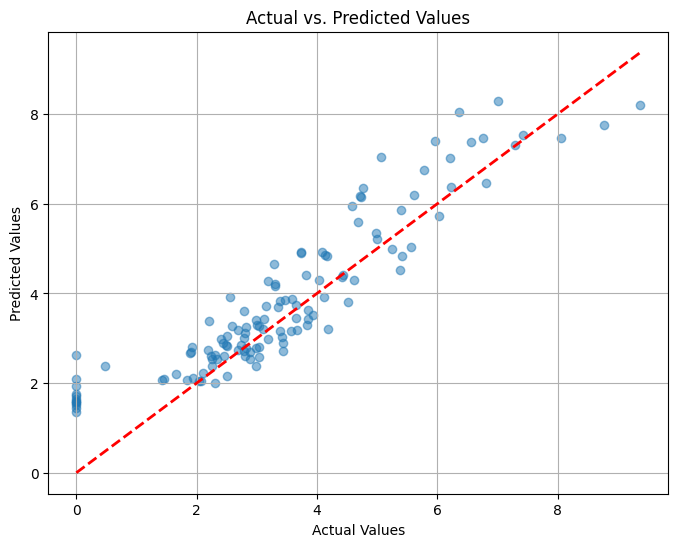

In [25]:
estimators = [i*100 for i in range(5, 11)]
depths = [i for i in range(6, 11)]
leaf_samples = [i*5 for i in range(2, 6)]
forest_mod = random_forest_regression(data_pars, y_var, y_var_name, estimators, depths, leaf_samples)

Linear Regression

Mean Absolute Error (MAE): 2436394483.7019
R-squared (R2): -28611209668768440320.0000
Variable Names with Coefficients:
Ros: 30422163468232.6016
GP: 0.2461
G: -0.2285
A1: -0.0352
SOG: 0.4531
Position_D: -0.0527
Age_t_minus_1: -435577279844.1064
GP_t_minus_1: 0.2461
G_t_minus_1: -0.2725
SOG_t_minus_1: 0.0029
Shot%_t_minus_1: -0.2607
Hit_t_minus_1: -0.0820
Age_t_minus_2: 435577279844.2461
Ros_t_minus_2: -30422163468229.3984
GP_t_minus_2: 7683454576.5654
G_t_minus_2: -0.0488
SOG_t_minus_2: -0.4307
Hit_t_minus_2: 0.0332
A2_twoyrtr: -0.2852
Age Ros: 1410161660657.7803
Age Shot%_t_minus_1: 0.4531
Age Ros_t_minus_2: -1410161660658.3496
Age A2_twoyrtr: -0.1436
Ros^2: -0.8745
Ros GP: -0.3408
Ros Blk: 0.0195
Ros TOIES: 0.1953
Ros TOISH: -0.0820
Ros Position_D: 693850528536.7988
Ros Position_D_t_minus_1: 422352174234.5815
Ros Cor_t_minus_2: -0.0498
Ros Position_D_t_minus_2: -1116202702771.5388
Ros GP_oneyrtr: -1436849511963.0000
Ros Shot%_twoyrtr: 0.0907
Ros TS%_oneyrtr: -0.2788
Ros TOISH_oneyrtr

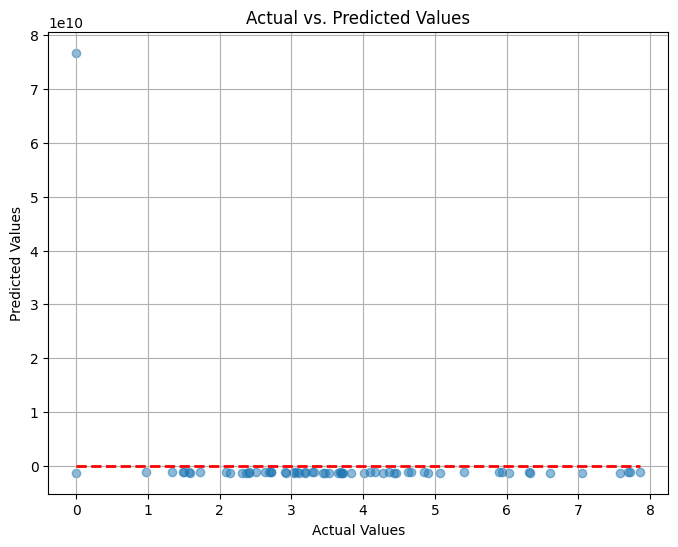

In [26]:
linear_mod = linear_regression(data_pars, y_var, y_var_name)

Elastic Net

Fitting 10 folds for each of 10000 candidates, totalling 100000 fits
Mean Absolute Error (MAE): 0.6405
R-squared (R2): 0.8378
Variable Names with Coefficients:
Ros: 1.6491
GP: 0.3397
G: 0.2874
A1: 0.0495
SOG: 0.0154
Position_D: -0.0340
Age_t_minus_1: 0.0568
GP_t_minus_1: 0.0453
G_t_minus_1: 0.0624
SOG_t_minus_1: 0.0000
Shot%_t_minus_1: 0.0150
Hit_t_minus_1: 0.0269
Age_t_minus_2: 0.0000
Ros_t_minus_2: -0.1256
GP_t_minus_2: 0.0539
G_t_minus_2: 0.0158
SOG_t_minus_2: 0.0318
Hit_t_minus_2: 0.0319
A2_twoyrtr: -0.0147
Age Ros: -0.0828
Age Shot%_t_minus_1: 0.0217
Age Ros_t_minus_2: -0.0207
Age A2_twoyrtr: -0.0303
Ros^2: -0.0154
Ros GP: -0.0529
Ros Blk: -0.0179
Ros TOIES: -0.0031
Ros TOISH: -0.0397
Ros Position_D: -0.0420
Ros Position_D_t_minus_1: -0.0032
Ros Cor_t_minus_2: 0.0887
Ros Position_D_t_minus_2: -0.0000
Ros GP_oneyrtr: -0.0394
Ros Shot%_twoyrtr: -0.0491
Ros TS%_oneyrtr: -0.0909
Ros TOISH_oneyrtr: -0.0428
G^2: 0.0464
G A1: 0.0214
G SOG: 0.0022
G Team_COL: 0.0320
G Team_TOR: 0.0313
G G

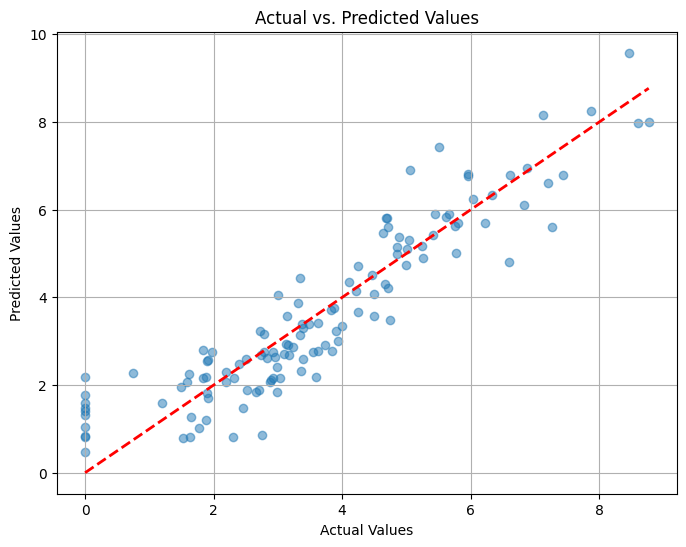

In [27]:
alphas = np.linspace(0, 5, 500)
ratios = np.linspace(0.05, 1, 20)
elastic_mod = elastic_net(data_pars, y_var, y_var_name, alphas, ratios)

Support Vector Regression

Fitting 10 folds for each of 9000 candidates, totalling 90000 fits
Mean Absolute Error (MAE): 0.6509
R-squared (R2): 0.8454


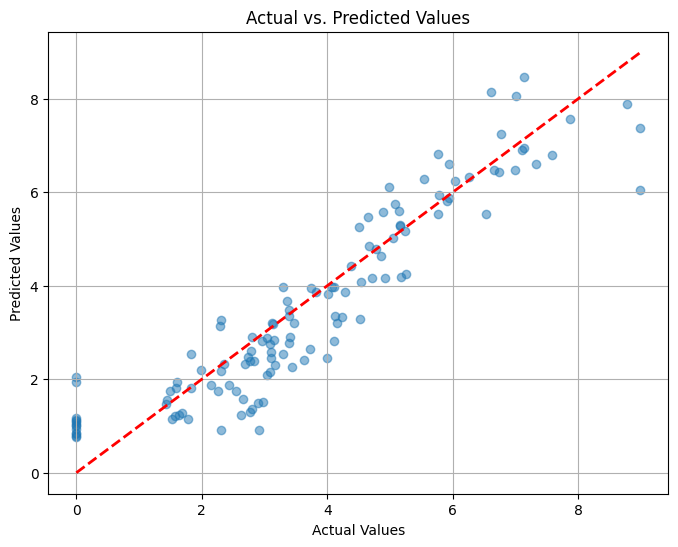

In [28]:
Cs = np.linspace(0.01, 3, 60)
kernels = ['linear', 'rbf', 'poly']
epsilons = np.linspace(1, 25, 50)
svr_mod = support_vector_regression(data_pars, y_var, y_var_name, Cs, kernels, epsilons)

Gradient Boosting

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Mean Absolute Error (MAE): 0.7066
R-squared (R2): 0.8184
Feature Importances:
Ros: 0.0261
GP: 0.0011
G: 0.0004
A1: 0.0011
SOG: 0.0042
Position_D: 0.0195
Age_t_minus_1: 0.0032
GP_t_minus_1: 0.0020
G_t_minus_1: 0.0026
SOG_t_minus_1: 0.0129
Shot%_t_minus_1: 0.0035
Hit_t_minus_1: 0.0013
Age_t_minus_2: 0.0000
Ros_t_minus_2: 0.0000
GP_t_minus_2: 0.0014
G_t_minus_2: 0.0085
SOG_t_minus_2: 0.0027
Hit_t_minus_2: 0.0012
A2_twoyrtr: 0.0023
Age Ros: 0.5669
Age Shot%_t_minus_1: 0.0033
Age Ros_t_minus_2: 0.0000
Age A2_twoyrtr: 0.0021
Ros^2: 0.0000
Ros GP: 0.1425
Ros Blk: 0.0021
Ros TOIES: 0.0168
Ros TOISH: 0.0035
Ros Position_D: 0.0012
Ros Position_D_t_minus_1: 0.0000
Ros Cor_t_minus_2: 0.0018
Ros Position_D_t_minus_2: 0.0000
Ros GP_oneyrtr: 0.0024
Ros Shot%_twoyrtr: 0.0028
Ros TS%_oneyrtr: 0.0025
Ros TOISH_oneyrtr: 0.0065
G^2: 0.0000
G A1: 0.0018
G SOG: 0.0030
G Team_COL: 0.0038
G Team_TOR: 0.0000
G G_t_minus_1: 0.0008
G PPP_t_minus_1: 0

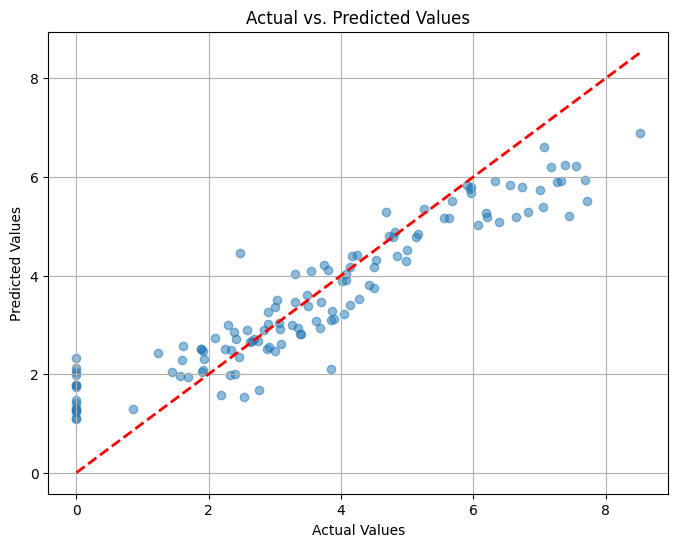

In [29]:
estimators = [i*100 for i in range(6, 11)]
depths = [i for i in range(6, 11)]
learn_rates = [0.05, 0.005]
boost_mod = gradient_boosting(data_pars, y_var, y_var_name, estimators, depths, learn_rates)

# Ensemble Predictions

Ensemble Functions

In [30]:
def ensemble_val(data, y_var, y_var_name, mod_one, mod_two, mod_three, mod_four):
    '''
    This model determines good proprtions for the ensemble model
    '''

    best_mse = float('inf')

    # Create train / test data
    train_data_x, test_data_x, train_data_y, test_data_y = train_test_split(data, y_var, test_size=0.2)
    xvarnames, X_train_scaled = standardize_prep(train_data_x)
    X_test_scaled = standardize_prep(test_data_x)[1]
    y_train = train_data_y[y_var_name].values
    y_test = test_data_y[y_var_name].values
    
    # Find best proportion combination
    props_one = np.linspace(0,1,26)
    for prop_one in props_one:
        props_two = np.linspace(0, (1-prop_one), int((1-prop_one)*25) + 1)
        for prop_two in props_two:
                props_three = np.linspace(0, (1-prop_one-prop_two), int((1-prop_one-prop_two)*25) + 1)
                for prop_three in props_three:
                    remainder = (1-prop_one-prop_two-prop_three)

                    y_pred = prop_one*mod_one.predict(X_train_scaled) + prop_two*mod_two.predict(X_train_scaled) + prop_three*mod_three.predict(X_train_scaled) + remainder*mod_four.predict(X_train_scaled)
                    mse = mean_squared_error(y_train, y_pred)

                    if mse < best_mse:
                        best_mse = mse
                        best_prop_one = prop_one
                        best_prop_two = prop_two
                        best_prop_three = prop_three
                        best_remainder = remainder

                print(f'Progress: prop_one is {prop_one}, prop_two is {prop_two}, prop_three is {prop_three}, best_mse is {best_mse}')

    # Fit model with best proprtions
    y_pred = best_prop_one*mod_one.predict(X_test_scaled) + best_prop_two*mod_two.predict(X_test_scaled) + best_prop_three*mod_three.predict(X_test_scaled) + best_remainder*mod_four.predict(X_test_scaled)

    # Performance metrics and charts
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}")

    # Plot predicted vs. actual values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
    plt.grid(True)
    plt.show()

    return [best_prop_one, best_prop_two, best_prop_three, best_remainder], [mod_one, mod_two, mod_three, mod_four]

Ensemble

Progress: prop_one is 0.0, prop_two is 0.0, best_mse is 0.4623578883651771
Progress: prop_one is 0.0, prop_two is 0.04, best_mse is 0.4406098097771469
Progress: prop_one is 0.0, prop_two is 0.08, best_mse is 0.41994390776577933
Progress: prop_one is 0.0, prop_two is 0.12, best_mse is 0.4000239217142721
Progress: prop_one is 0.0, prop_two is 0.16, best_mse is 0.3811812311277537
Progress: prop_one is 0.0, prop_two is 0.2, best_mse is 0.36323817921432494
Progress: prop_one is 0.0, prop_two is 0.24, best_mse is 0.3462187019209809
Progress: prop_one is 0.0, prop_two is 0.28, best_mse is 0.33025258374922795
Progress: prop_one is 0.0, prop_two is 0.32, best_mse is 0.3150563192122051
Progress: prop_one is 0.0, prop_two is 0.36, best_mse is 0.3009422079846597
Progress: prop_one is 0.0, prop_two is 0.4, best_mse is 0.2876940776815088
Progress: prop_one is 0.0, prop_two is 0.44, best_mse is 0.27540319662290763
Progress: prop_one is 0.0, prop_two is 0.48, best_mse is 0.2641319971634977
Progress: p

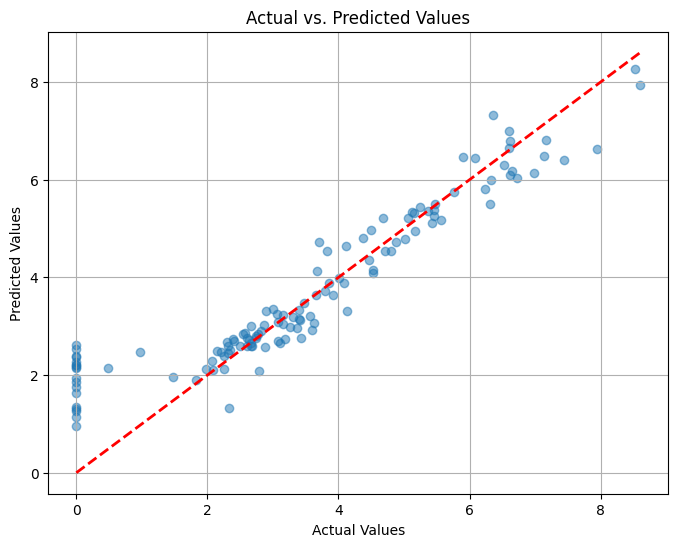

[0.0, 0.92, 0.0, 0.07999999999999996]


In [31]:
props, mods = ensemble_val(data_pars, y_var, y_var_name, svr_mod, boost_mod, forest_mod, elastic_mod)
print(props)

# Prediction

In [32]:
# Standardize
X_scaled = standardize_prep(pred_data_pars)[1]

# Predict
y_pred = props[0]*mods[0].predict(X_scaled) + props[1]*mods[1].predict(X_scaled) + props[2]*mods[2].predict(X_scaled) + props[3]*mods[3].predict(X_scaled)

# Create a DataFrame for the predictions with the same index as pred_data_pars
predictions_df = pd.DataFrame(data=y_pred, index=pred_data_pars.index, columns=['FP/G'])

# Concatenate the predictors and predictions into a single DataFrame
combined_df = pd.concat([pred_data_pars, predictions_df], axis=1)
combined_df.to_csv('predictions.csv')